In [231]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [232]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati_profit.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

#df = df.dropna(subset=['relative_quarterly_return'])

df.count()

datadate                          15175
tic                               15175
rdq                               15175
actq                              12966
epsfiq                            15101
teqq                               9611
dvpspq                            15144
PRC                               15172
spindx                            15175
ptb                                9548
div_yield                         15143
pe_inc                            15101
actq_change                       15174
epsfiq_change                     15160
teqq_change                       15065
dvpspq_change                     12089
ptb_change                        15065
div_yield_change                  12089
pe_inc_change                     15160
PRC_change                        15081
next_PRC_change                   15081
spindx_change                     15082
next_spindx_change                15082
relative_quarterly_return         15081
next_relative_quarterly_return    15081


In [233]:
df = df.dropna()
#df.info()

In [234]:
# Find the unique number of stocks in the dataframe
unique_stocks = df['tic'].unique()

# Print the result
print(f"Number of unique stocks: {len(unique_stocks)}")
print(unique_stocks)

df = df.sort_values(by=['datadate'])


Number of unique stocks: 79
['AAPL' 'ABT' 'ADM' 'AFL' 'AMGN' 'AMT' 'AON' 'APD' 'BA' 'BAX' 'BMY' 'CAT'
 'CL' 'CME' 'COP' 'COST' 'CSCO' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL' 'EQIX'
 'ETN' 'EXC' 'EXPE' 'F' 'FDX' 'FIS' 'GE' 'GOOGL' 'HCA' 'HD' 'IBM' 'INTC'
 'JBL' 'JCI' 'JNJ' 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'MDT' 'META'
 'MMC' 'MMM' 'MRK' 'MSFT' 'MU' 'NKE' 'NOC' 'NVDA' 'OXY' 'PFE' 'PG' 'PPL'
 'PYPL' 'QCOM' 'RTX' 'SBUX' 'SPGI' 'STZ' 'T' 'TGT' 'TMO' 'TSLA' 'TSN'
 'UNH' 'UPS' 'V' 'VZ' 'WBA' 'WDC' 'WMT' 'XOM' 'ZTS']


In [235]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

#df = df[~df['tic'].isin(tickers_to_drop)]

In [236]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_PRC_change'], ascending=[True, False])
test_df.head(10)


,datadate,tic,rdq,actq,epsfiq,teqq,dvpspq,PRC,spindx,ptb,...,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,PRC_change,next_PRC_change,spindx_change,next_spindx_change,relative_quarterly_return,next_relative_quarterly_return
14476,2013-03-31,WDC,2013-04-24,7340.0,1.600000,8423.0,0.0000,52.900000,1578.79,1.424744,...,-1.000000,0.152990,-1.000000,0.176471,0.123858,0.276560,0.056181,0.067868,0.067677,0.208691
13626,2013-03-31,TSN,2013-05-06,5299.0,0.260000,6114.0,0.0500,24.100000,1617.50,1.406658,...,-0.666667,0.157404,-0.714390,-0.458333,0.057018,0.231950,0.068948,0.055419,-0.011930,0.176531
9890,2013-03-31,MSFT,2013-04-18,93524.0,0.720000,76688.0,0.2300,28.790000,1541.61,3.102768,...,0.000000,-0.007199,-0.049603,-0.052632,0.041983,0.230983,0.031301,0.095848,0.010682,0.135135
10506,2013-03-31,NOC,2013-04-24,7846.0,2.030000,9469.0,0.5500,73.770000,1578.79,1.740641,...,0.000000,0.022073,-0.033825,-0.051402,0.111999,0.224075,0.051153,0.067868,0.060846,0.156206
8236,2013-03-31,LMT,2013-04-23,14872.0,2.330000,304.0,1.1500,97.060000,1578.78,98.810829,...,0.000000,-0.870935,-0.015297,0.346821,0.040858,0.214919,0.056167,0.071961,-0.015309,0.142958
6998,2013-03-31,JCI,2013-04-23,12826.0,0.251309,12032.0,0.0000,35.068063,1578.78,1.849821,...,-1.000000,0.123845,-1.000000,-0.538462,0.079974,0.207226,0.062450,0.070048,0.017524,0.137178
3121,2013-03-31,CME,2013-05-02,12297.8,0.710000,21555.8,0.4500,60.400000,1597.59,0.929604,...,-0.742857,0.099239,-0.767261,0.420000,0.020615,0.194868,0.057104,0.068403,-0.036488,0.126465
13782,2013-03-31,UNH,2013-04-18,22717.0,1.160000,31757.0,0.2125,59.690000,1541.61,1.855024,...,0.000000,0.054098,-0.074102,-0.033333,0.097243,0.181940,0.040967,0.095848,0.056275,0.086092
1949,2013-03-31,APD,2013-04-23,3379.2,1.380000,6517.4,0.6400,85.180000,1578.78,2.774582,...,0.000000,0.005644,-0.012366,0.053435,-0.036861,0.181615,0.056174,0.071961,-0.093036,0.109655
2158,2013-03-31,BA,2013-04-24,59490.0,1.440000,7560.0,0.4850,90.830000,1578.79,8.656261,...,0.102273,-0.095258,-0.034968,0.125000,0.217724,0.177474,0.051153,0.067868,0.166570,0.109606


In [237]:
results = test_df[['datadate', 'rdq', 'tic', 'next_PRC_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['datadate', 'tic', 'rdq', 'spindx', 'spindx_change', 'next_spindx_change', 'PRC', 'PRC_change', 'next_PRC_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,epsfiq,teqq,dvpspq,ptb,div_yield,pe_inc,actq_change,epsfiq_change,teqq_change,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,relative_quarterly_return,next_relative_quarterly_return
2659,1027.720,0.035833,1030.791,0.35,31.305088,0.007413,0.002986,-0.962807,-0.065217,0.004846,0.0,-0.092305,0.096629,-0.065217,-0.080031,0.083710
2868,458.928,0.015833,357.164,0.35,115.469355,0.005831,0.000330,-0.990440,-0.025641,-0.982583,0.0,16.724700,-0.168471,-0.025641,0.185592,-0.031692
3940,2009.928,0.095000,4919.473,0.70,10.119448,0.019087,0.005938,-0.971345,-0.044025,-0.933976,0.0,7.361167,-0.043854,-0.044025,-0.035313,-0.112417
4664,481.099,0.053889,481.521,0.35,29.163632,0.008106,0.002994,-0.876177,0.672414,0.025038,0.0,-0.010848,-0.013510,0.672414,-0.003676,0.022074
9429,398.303,0.012361,520.653,0.55,650.108088,0.004266,0.000172,-0.975410,-0.082474,-0.889949,0.0,59.147677,-0.128822,-0.082474,0.085909,0.059783


In [238]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return',], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return',], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return',], 1)

X_train.head()

,actq,epsfiq,teqq,dvpspq,ptb,div_yield,pe_inc,actq_change,epsfiq_change,teqq_change,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,relative_quarterly_return
2659,1027.720,0.035833,1030.791,0.35,31.305088,0.007413,0.002986,-0.962807,-0.065217,0.004846,0.0,-0.092305,0.096629,-0.065217,-0.080031
2868,458.928,0.015833,357.164,0.35,115.469355,0.005831,0.000330,-0.990440,-0.025641,-0.982583,0.0,16.724700,-0.168471,-0.025641,0.185592
3940,2009.928,0.095000,4919.473,0.70,10.119448,0.019087,0.005938,-0.971345,-0.044025,-0.933976,0.0,7.361167,-0.043854,-0.044025,-0.035313
4664,481.099,0.053889,481.521,0.35,29.163632,0.008106,0.002994,-0.876177,0.672414,0.025038,0.0,-0.010848,-0.013510,0.672414,-0.003676
9429,398.303,0.012361,520.653,0.55,650.108088,0.004266,0.000172,-0.975410,-0.082474,-0.889949,0.0,59.147677,-0.128822,-0.082474,0.085909


In [239]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,epsfiq,teqq,dvpspq,ptb,div_yield,pe_inc,actq_change,epsfiq_change,teqq_change,dvpspq_change,ptb_change,div_yield_change,pe_inc_change,relative_quarterly_return
0,0.009291,0.847915,0.018366,0.056911,0.027374,0.007171,0.994372,0.001301,0.553180,0.178442,0.185185,0.053481,0.106611,0.553180,0.007797
1,0.003818,0.847159,0.013044,0.056911,0.055885,0.005641,0.994368,0.000091,0.553507,0.162020,0.185185,0.197662,0.080839,0.553507,0.010462
2,0.018743,0.850151,0.049087,0.113821,0.020197,0.018463,0.994376,0.000927,0.553355,0.162828,0.185185,0.117384,0.092954,0.553355,0.008246
3,0.004031,0.848597,0.014027,0.056911,0.026649,0.007841,0.994372,0.005094,0.559276,0.178778,0.185185,0.054180,0.095904,0.559276,0.008563
4,0.003235,0.847028,0.014336,0.089431,0.236995,0.004127,0.994368,0.000749,0.553037,0.163560,0.185185,0.561376,0.084693,0.553037,0.009462


In [240]:
'''

model = xgb.XGBRanker(
    objective="rank:pairwise",  
    eval_metric="ndcg",
    learning_rate=0.05,
    max_depth=8,
    gamma=0.1,
    random_state=42,
    n_estimators=300
)

# Fit model with `group`
model.fit(X_train, y_train, group=train_group)

'''

'\n\nmodel = xgb.XGBRanker(\n    objective="rank:pairwise",  \n    eval_metric="ndcg",\n    learning_rate=0.05,\n    max_depth=8,\n    gamma=0.1,\n    random_state=42,\n    n_estimators=300\n)\n\n# Fit model with `group`\nmodel.fit(X_train, y_train, group=train_group)\n\n'

In [241]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [8],
    'gamma': [0.1],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[11:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.




/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[11:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[11:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[11:22:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[11:22:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[11:22:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = -3168.958314675125
CPU times: user 12.4 s, sys: 567 ms, total: 13 s
Wall time: 2.02 s


In [242]:

%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)



CPU times: user 2.27 s, sys: 111 ms, total: 2.38 s
Wall time: 409 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

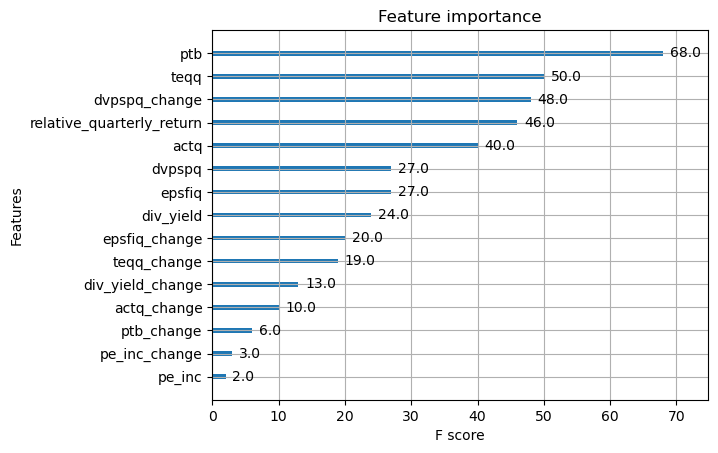

In [243]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [244]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_train_binary, y_train_pred_binary))



[ 0.01933637  0.00506456 -0.00220543 ...  0.0074106   0.00296852
  0.01215186]
              precision    recall  f1-score   support

           0       0.62      0.53      0.57      1560
           1       0.56      0.65      0.60      1452

    accuracy                           0.59      3012
   macro avg       0.59      0.59      0.59      3012
weighted avg       0.59      0.59      0.59      3012



In [245]:
results['y_pred'] = y_test_pred
results1 = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results1.head(60)



,datadate,rdq,tic,next_PRC_change,next_relative_quarterly_return,y_pred
3450,2013-03-31,2013-03-12,COST,0.078361,0.012705,0.692230
3121,2013-03-31,2013-05-02,CME,0.194868,0.126465,0.358519
6098,2013-03-31,2013-05-02,HCA,-0.034346,-0.102749,0.273910
4105,2013-03-31,2013-04-26,CVX,0.040903,-0.039635,0.249995
126,2013-03-31,2013-04-23,AAPL,0.031665,-0.040296,0.152435
12228,2013-03-31,2013-04-23,RTX,0.000000,-0.071961,0.141658
8236,2013-03-31,2013-04-23,LMT,0.214919,0.142958,0.093554
2824,2013-03-31,2013-04-22,CAT,0.008826,-0.070176,0.020672
6998,2013-03-31,2013-04-23,JCI,0.207226,0.137178,0.019986
14476,2013-03-31,2013-04-24,WDC,0.276560,0.208691,0.019336


In [246]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = results.groupby('datadate').agg(
    stocks=('next_PRC_change', 'size'),
    baseline=('next_PRC_change', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_PRC_change',
        target_col='next_PRC_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred',
        target_col='next_PRC_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the ideal bottom 10, weight by the actual returns
df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_PRC_change',
        target_col='next_PRC_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(10)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,65,0.062099,0.085235,0.245133,0.115081,-0.130966
1,2013-06-30,58,0.048163,-0.002837,0.240235,0.214443,-0.132527
2,2013-09-30,66,0.022972,0.015275,0.267273,0.076405,-0.430914
3,2013-12-31,66,0.172798,2.130138,3.588420,0.051306,-0.065939
4,2014-03-31,65,0.040261,0.047322,0.199853,0.113371,-0.071427
5,2014-06-30,65,0.013562,-0.038744,0.184739,0.081205,-0.114773
6,2014-09-30,66,0.057451,-0.004828,0.292970,-0.023910,-0.153773
7,2014-12-31,66,0.022863,0.032048,0.193613,-0.008934,-0.215445
8,2015-03-31,66,0.010390,0.105597,0.603051,0.066996,-0.300661
9,2015-06-30,68,-0.012132,0.002126,0.182889,0.011355,-0.169460


In [247]:
for portfolio in ['baseline', 'top_10', 'bottom_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.029916449026600914
Sharpe Ratio of the baseline portfolio: 0.09524722721183972

Mean quarterly return of the top_10 portfolio: 0.09040447630379027
Sharpe Ratio of the top_10 portfolio: 0.19500673718555311

Mean quarterly return of the bottom_10 portfolio: 0.050799874242443185
Sharpe Ratio of the bottom_10 portfolio: 0.3022209094565578



In [248]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


In [249]:
train_df = train_df[important_features + ['next_relative_quarterly_return']]
valid_df = valid_df[important_features + ['next_relative_quarterly_return']]
test_df  = test_df[important_features + ['next_relative_quarterly_return']]

y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return'], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return'], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return'], 1)

# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,ptb,teqq,dvpspq_change,relative_quarterly_return,actq
0,0.027374,0.018366,0.185185,0.007797,0.009291
1,0.055885,0.013044,0.185185,0.010462,0.003818
2,0.020197,0.049087,0.185185,0.008246,0.018743
3,0.026649,0.014027,0.185185,0.008563,0.004031
4,0.236995,0.014336,0.185185,0.009462,0.003235


In [250]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0.1,
    'random_state': 42
}
eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [251]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_test_binary, y_test_pred_binary))


[0.00411842 0.00411842 0.00210821 ... 0.00488995 0.00488995 0.00057506]
              precision    recall  f1-score   support

           0       0.51      0.29      0.37      1437
           1       0.50      0.71      0.58      1412

    accuracy                           0.50      2849
   macro avg       0.50      0.50      0.48      2849
weighted avg       0.50      0.50      0.48      2849



In [252]:
results['y_pred_import'] = y_test_pred
results = results.sort_values(by=['datadate', 'y_pred'], ascending=[True, False])

results.head(5)

,datadate,rdq,tic,next_PRC_change,next_relative_quarterly_return,y_pred,y_pred_import
3450,2013-03-31,2013-03-12,COST,0.078361,0.012705,0.692230,0.004890
3121,2013-03-31,2013-05-02,CME,0.194868,0.126465,0.358519,0.033447
6098,2013-03-31,2013-05-02,HCA,-0.034346,-0.102749,0.273910,-0.086362
4105,2013-03-31,2013-04-26,CVX,0.040903,-0.039635,0.249995,0.000899
126,2013-03-31,2013-04-23,AAPL,0.031665,-0.040296,0.152435,-0.038632


In [253]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_import'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred_import',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_import'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred_import',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(10)


KeyError: 'next_prccq_change'

In [ ]:
for portfolio in ['top_10', 'top_10_import']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the top_10 portfolio: 0.20581700842274153
Sharpe Ratio of the top_10 portfolio: 1.319828079735179

Mean quarterly return of the top_10_import portfolio: 0.2000897774134724
Sharpe Ratio of the top_10_import portfolio: 1.5004188408005699

